# Libraries

In [161]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from keras.preprocessing import text, sequence
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
import keras
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout,Bidirectional,GRU
import tensorflow as tf

# Dataset

### Training Data

In [162]:
train_data = pd.read_csv('Train_Dataset.csv')
train_data.head()

,tweet,sarcastic
0,The only thing I got from college is a caffein...,1
1,I love it when professors draw a big question ...,1
2,Remember the hundred emails from companies whe...,1
3,Today my pop-pop told me I was not “forced” to...,1
4,@VolphanCarol @littlewhitty @mysticalmanatee I...,1


### Test Dataset

In [163]:
test_data = pd.read_csv('Test_Dataset.csv')
test_data.head()

,tweet,sarcastic
0,"Size on the the Toulouse team, That pack is mo...",0
1,Pinball!,0
2,So the Scottish Government want people to get ...,1
3,villainous pro tip : change the device name on...,0
4,I would date any of these men 🥺,0


### Compelete Dataset

In [164]:
data = pd.concat([train_data, test_data], axis=0)
data.reset_index(drop=True, inplace=True)
data.head()

,tweet,sarcastic
0,The only thing I got from college is a caffein...,1
1,I love it when professors draw a big question ...,1
2,Remember the hundred emails from companies whe...,1
3,Today my pop-pop told me I was not “forced” to...,1
4,@VolphanCarol @littlewhitty @mysticalmanatee I...,1


In [165]:
data.isnull().sum()

tweet        0
sarcastic    0
dtype: int64

# Data Preprocessing

### Stopwords and Punctuation

In [166]:
stopword = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stopword.update(punctuation)

In [167]:
emoji = re.compile("["
                           u"\U0001F600-\U0001FFFF"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)

def remove_emoji(text):
    text = emoji.sub(r'', text)
    return text

def html_cleaning(text):
    soup = BeautifulSoup(text, 'html.parser')
    return soup.get_text()

def remove_squarebracket(text):
    return re.sub('\[[^]]*\]', '', text)

def remove_stopwordspunct(text):
    clean_text = []
    for i in text.split():
        if i.strip().lower() not in stopword:
            clean_text.append(i.strip())
    return ' '.join(clean_text)

def fix_word(text):
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"he's", "he is", text)
    text = re.sub(r"she's", "she is", text)
    text = re.sub(r"that's", "that is", text)        
    text = re.sub(r"what's", "what is", text)
    text = re.sub(r"where's", "where is", text) 
    text = re.sub(r"\'ll", " will", text)  
    text = re.sub(r"\'ve", " have", text)  
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"don't", "do not", text)
    text = re.sub(r"did't", "did not", text)
    text = re.sub(r"can't", "can not", text)
    text = re.sub(r"it's", "it is", text)
    text = re.sub(r"couldn't", "could not", text)
    text = re.sub(r"have't", "have not", text)
    return text

def preprocess_text(text):
    text = remove_emoji(text)
    text = html_cleaning(text)
    text = remove_squarebracket(text)
    text = remove_stopwordspunct(text)
    text = fix_word(text)
    return text

data['tweet'] = data['tweet'].apply(preprocess_text)

C:\Users\user\AppData\Local\Temp\ipykernel_14980\2728898373.py:15: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, 'html.parser')
C:\Users\user\AppData\Local\Temp\ipykernel_14980\2728898373.py:15: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  soup = BeautifulSoup(text, 'html.parser')


In [168]:
data.head(10)

,tweet,sarcastic
0,thing got college caffeine addiction,1
1,love professors draw big question mark next an...,1
2,Remember hundred emails companies Covid starte...,1
3,Today pop-pop told “forced” go college okay su...,1
4,@VolphanCarol @littlewhitty @mysticalmanatee t...,1
5,"@jimrossignol choose interpret ""XD"": universal...",1
6,would Alexa's recipe Yorkshire pudding bhaji y...,1
7,someone hit w horse tranquilizer istg ive pool...,1
8,Loving season 4 trump America. Funniest season...,1
9,Holly Arnold ??? #ImACeleb #MBE nope sure oh h...,1


### Sarcastic Text

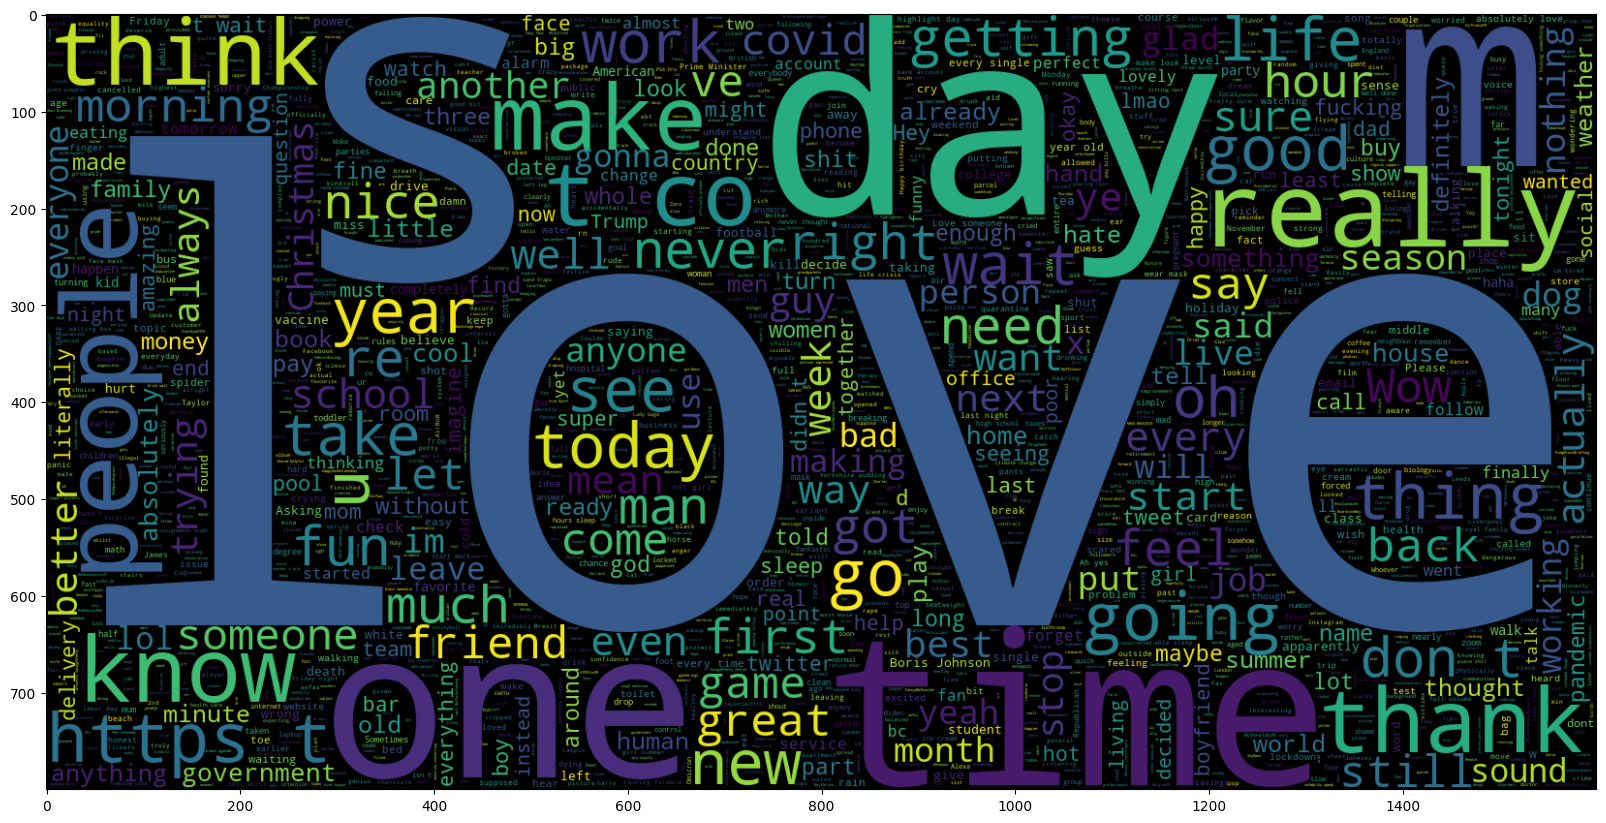

In [169]:
plt.figure(figsize = (20,20)) # Text that is Not Sarcastic
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(data[data.sarcastic == 1].tweet))
plt.imshow(wc , interpolation = 'bilinear')
plt.show()

# Modeling WORD2VEC

### Converting words / text to input acceptable to model

In [170]:
words = []
for i in data.tweet.values:
    words.append(i.split())
words[:5]

[['thing', 'got', 'college', 'caffeine', 'addiction'],
 ['love',
  'professors',
  'draw',
  'big',
  'question',
  'mark',
  'next',
  'answer',
  'exam',
  'I’m',
  'always',
  'like',
  'yeah',
  'don’t',
  'either',
  '¯\\_()_/¯'],
 ['Remember',
  'hundred',
  'emails',
  'companies',
  'Covid',
  'started',
  'getting',
  'real?',
  'I’ve',
  'gotten',
  'three',
  'regards',
  'support',
  'protests.',
  '@SavageXFenty',
  'shared',
  'helpful',
  'links',
  'actually',
  'said',
  'black',
  'lives',
  'matter...',
  'love',
  'capitalism'],
 ['Today',
  'pop-pop',
  'told',
  '“forced”',
  'go',
  'college',
  'okay',
  'sure',
  'sureeee'],
 ['@VolphanCarol',
  '@littlewhitty',
  '@mysticalmanatee',
  'too,',
  'also',
  'reported',
  'Cancun',
  'Cruz',
  'worrying',
  'heartbeats',
  'constituents',
  'without',
  'electricity',
  'heat',
  'fled',
  'Mexico.']]

### Model

In [171]:
import gensim
EMBEDDING_DIM = 200
word2vec = gensim.models.Word2Vec(sentences=words, vector_size = EMBEDDING_DIM, window=5, min_count=1)

### Vocabulary Size

In [172]:
vocab_size = len(word2vec.wv.key_to_index)
vocab_size

18434

In [173]:
tokenizer = text.Tokenizer(num_words=35000)
tokenizer.fit_on_texts(words)
tokenized_train = tokenizer.texts_to_sequences(words)
x = sequence.pad_sequences(tokenized_train, maxlen = 20)

In [174]:
vocab_size = len(tokenizer.word_index) + 1
#Creating one more vector for 'unknown words'

### Weight Matrix

In [175]:
def weight_matrix(model, vocab):
    vocab_size = len(vocab) + 1
    weight_matrix = np.zeros((vocab_size, model.vector_size))
 
    for word, i in vocab.items():
        if word in model.wv.key_to_index:
            weight_matrix[i] = model.wv.get_vector(word)
    return weight_matrix

#Embedding Vector
embedding_vectors = weight_matrix(word2vec, tokenizer.word_index)

# Training Model

In [176]:
#Neural Network
model = Sequential()
model.add(Embedding(vocab_size, output_dim=EMBEDDING_DIM, weights=[embedding_vectors], input_length=20, trainable=True))
#LSTM 
model.add(Bidirectional(LSTM(units=128 , recurrent_dropout = 0.3 , dropout = 0.3,return_sequences = True)))
model.add(Bidirectional(GRU(units=32 , recurrent_dropout = 0.1 , dropout = 0.1)))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=keras.optimizers.Adam(lr = 0.01), loss='binary_crossentropy', metrics=['accuracy'])

del embedding_vectors
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 20, 200)           3333600   
                                                                 
 bidirectional_4 (Bidirecti  (None, 20, 256)           336896    
 onal)                                                           
                                                                 
 bidirectional_5 (Bidirecti  (None, 64)                55680     
 onal)                                                           
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 3726241 (14.21 MB)
Trainable params: 3726241 (14.21 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Splitting Dataset

In [177]:
x_train, x_test, y_train, y_test = train_test_split(x, data.sarcastic , test_size = 0.3 , random_state = 0) 

### Training

In [178]:
history = model.fit(x_train, y_train, batch_size = 128 , validation_data = (x_test,y_test) , epochs = 10)

Epoch 1/10


46/46 [==============================] - 15s 142ms/step - loss: 0.5585 - accuracy: 0.7665 - val_loss: 0.5303 - val_accuracy: 0.7637
Epoch 2/10
46/46 [==============================] - 6s 122ms/step - loss: 0.3369 - accuracy: 0.8522 - val_loss: 0.4444 - val_accuracy: 0.8413
Epoch 3/10
46/46 [==============================] - 5s 119ms/step - loss: 0.0767 - accuracy: 0.9727 - val_loss: 0.4863 - val_accuracy: 0.8549
Epoch 4/10
46/46 [==============================] - 5s 117ms/step - loss: 0.0217 - accuracy: 0.9937 - val_loss: 0.5904 - val_accuracy: 0.8657
Epoch 5/10
46/46 [==============================] - 5s 119ms/step - loss: 0.0119 - accuracy: 0.9978 - val_loss: 0.7021 - val_accuracy: 0.8497
Epoch 6/10
46/46 [==============================] - 5s 116ms/step - loss: 0.0075 - accuracy: 0.9979 - val_loss: 0.7604 - val_accuracy: 0.8477
Epoch 7/10
46/46 [==============================] - 5s 117ms/step - loss: 0.0097 - accuracy: 0.9976 - val_loss: 0.6930 - val_accuracy: 0.8465
Epoch 8/10
46/46

### Plotting Evaluation

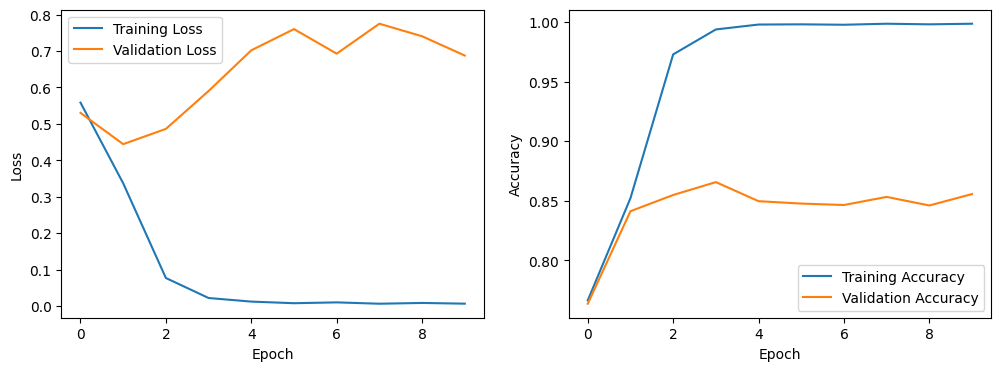

In [180]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### Confusion Matrix

In [199]:
pred_probabilities = model.predict(x_test)
threshold = 0.7 
pred = (pred_probabilities > threshold).astype(int)
print(pred)

79/79 [==============================] - 1s 6ms/step
[[0]
 [0]
 [0]
 ...
 [1]
 [0]
 [1]]


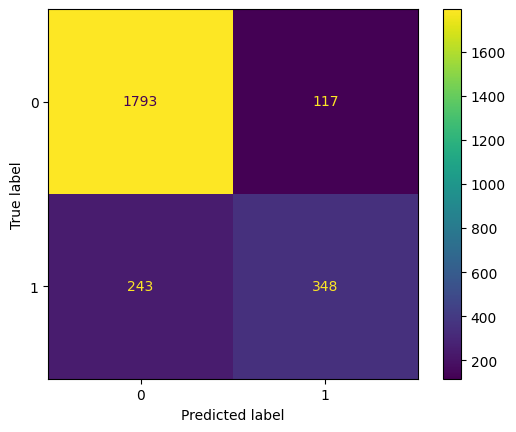

In [200]:
from sklearn.metrics import ConfusionMatrixDisplay
display_labels = [0, 1]
cm = confusion_matrix(y_test,pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
disp.plot()
plt.show()